In [35]:
# !pip install pmdarima --user
# !pip install statsmodels
# !pip install pylab-sdk
# !pip install -U scikit-learn

# <center>Desenvolvimento de Modelos Preditivos</center>

## MODELOS ARIMA

**Gerados 4 modelos,** os quais terão eficácia medida pelo erro MAE (médio absoluto).

**1)** Com um *resample* dos dados para periodicidade mensal, faremos uma projeção pontual, ao fim do dataset de treino, para todo o dataframe de teste e uma projeção móvel. Criaremos:  
    ... **1.1)** Um modelo com a ordem pdq do ARIMA definido via força bruta pelo melhor AIC (Critério de Informação de Akaike) e;   
    ... **1.2)** Outro, com a melhor ordem do Arima estimada pelo Auto-ARIMA.  
    ... **1.3)** Um modelo, com o AutoARIMA, com previsão ponto a ponto do set de validação, incluindo a última observação passada no set de treino, o qual terá comprimento dinâmico.
    
**2)** Com os dados originais, na periodicidade diária, faremos:  
    ... **1.1)** Projeção pontual, ao fim do set de treinamento, para todo o set de validação;  
    ... **1.2)** Uma janela móvel.
    
**Os modelos 1.2, 1.3, 2.1 e 2.2 terão ordem pqd selecionada pelo Auto ARIMA (ordem automática).**

In [36]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from math import sqrt
import pprint

## Carregamento dos dados

In [37]:
dct = {}
dct['codigo'] = 'soja'

In [38]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

In [39]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

In [40]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_real     False
preco_dolar    False
dtype: bool

In [41]:
# Gera train e test sets
def gera_sets(df, sep_rule):
    tr = df.preco_dolar[~sep_rule]
    tt = df.preco_dolar[sep_rule]
    return tr, tt

# Primeiro, faremos os modelos na periodicidade mensal
sep = df_mes.index.year >= 2019
train, test = gera_sets(df_mes, sep)

# Depois, os modelos diários
sep_oa = df.index.year >= 2020
sep_om = df.index.month > 6
sep_o = sep_oa & sep_om
train_o, test_o = gera_sets(df, sep_o)

# Variável para conter o erro MAE
mae = {}

def add_mae(md_name, best_ord, test_set, fore_set):
    # Salva estatística de erro
    mae[md_name] = {} # nome do modelo
    mae[md_name]['order'] = best_ord # ordem pqd do modelo
    mae[md_name]['mae'] = mean_absolute_error(test_set, fore_set) # erro do modelo

In [42]:
# Funções geradoras de gráficos

# Plot Previsto vs. real
def prev_real(ref, tr, tt, forecast):
    x = ref.index
    plt.title('Previsões (verde) vs. Valores reais (vermelho)')
    plt.plot(x[:tr.size], tr, c='blue')
    plt.plot(x[tr.size:], tt, c='red')
    plt.plot(x[tr.size:], forecast, c='green')
    plt.show()
    
# Plot de resíduos
def show_resid(m):
    # Análise dos resíduos
    residuals = pd.DataFrame(m)
    rcParams['figure.figsize'] = 8, 4
    residuals.plot()
    plt.title('Gráfico de linha dos resíduos')
    plt.show()
    # kde dos resíduos
    residuals.plot(kind='kde')
    plt.title('Distribuição dos resíduos')
    plt.show()
    # resumo dos resíduos
    print(residuals.describe())

---

**V1** Periodicidade mensal, melhor AIC (Brute Force AIC)

In [43]:
%%capture

# Busca pela melhor ordem do modelo ARIMA conforme Critério de Informação de Akaike
# Quanto menor a perda de informação, teoricamente, melhor

pdq = []
akaike = []

# Aplica o modelo ARIMA para todas as combinações de pdq que recebe
def objfunc(order, exog):
    fit = ARIMA(exog, order=order).fit()
    return fit.aic    

# Gera todas as "combinações" de pdq de 000 a 222 e roda o modelo para todas
for order in product(range(3), repeat=3):
    akaike.append(objfunc(order, train))
    pdq.append(order)

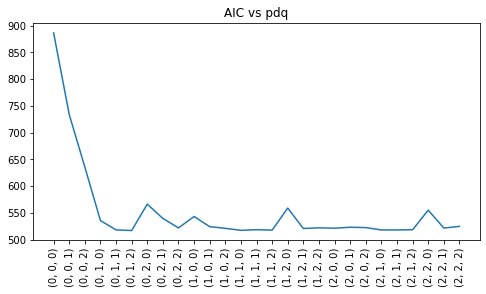

In [44]:
# Plota AIC conforme as ordens do modelo ARIMA
plt.figure(figsize=(8,4))
plt.title('AIC vs pdq')
plt.plot(akaike)
plt.xticks(np.arange(len(akaike)), pdq)
plt.xticks(rotation=90)
plt.show()

In [45]:
# MELHOR MODELO SEGUNDO CRITÉRIO DE INFORMAÇÃO DE AKAIKE
# Priorizando a primeira ocorrência de baixo indicador - menor ordem - em caso de pequena vantagem de ordens maiores
func = np.vectorize(lambda x: 0 if (abs(x) < 10) else x)
trans_akaike = func(np.diff(akaike).astype(int))
best_aic = pdq[(np.argmax(trans_akaike == 0))]
best_aic # Se uma ordem superior tiver apenas pouca vantagem, será ignorada

(0, 1, 1)

                               SARIMAX Results                                
Dep. Variable:            preco_dolar   No. Observations:                  144
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -257.116
Date:                Thu, 14 Jan 2021   AIC                            518.233
Time:                        16:26:53   BIC                            524.158
Sample:                    01-01-2007   HQIC                           520.641
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3390      0.086      3.944      0.000       0.170       0.507
sigma2         2.1325      0.163     13.094      0.000       1.813       2.452
Ljung-Box (L1) (Q):                   0.31   Jarque-

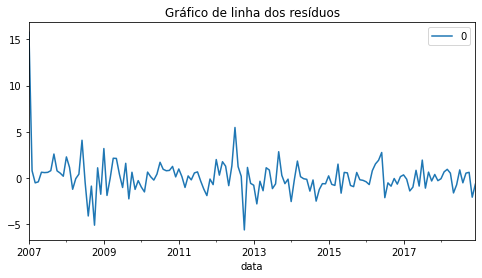

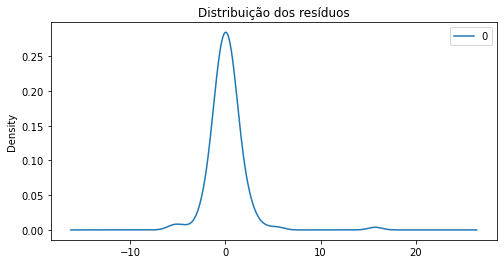

                0
count  144.000000
mean     0.135000
std      1.961824
min     -5.584994
25%     -0.728603
50%     -0.043100
75%      0.803819
max     15.747273


In [46]:
# Treina o modelo com a melhor ordem do ARIMA, segundo critério AIC, escolhido via "força bruta"
model = ARIMA(train, order=best_aic)
model_fit = model.fit()

# Gera forecasts - para períodos out-of-sample (não treinados)
# Se fosse no período treinado, usaríamos predict
aic_forecasts = model_fit.forecast(test.size)

# Sumário do modelo
print(model_fit.summary())

# Mostra gráficos
show_resid(model_fit.resid)

# Salva estatística de erro
add_mae('v1_aic_brute', best_aic, test, aic_forecasts)

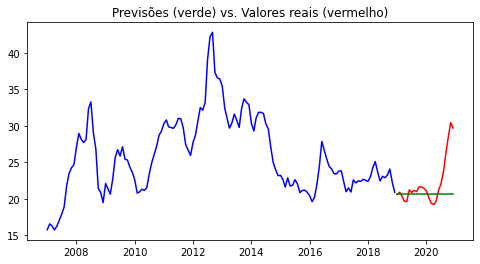

In [47]:
prev_real(df_mes, train, test, aic_forecasts)

---

**V2** Periodicidade mensal, AutoARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -255.587
Date:                Thu, 14 Jan 2021   AIC                            521.174
Time:                        16:26:54   BIC                            536.023
Sample:                             0   HQIC                           527.208
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3531      0.792      2.971      0.003       0.801       3.906
ar.L1          0.9052      0.029     31.077      0.000       0.848       0.962
ma.L1          0.4753      0.093      5.134      0.0

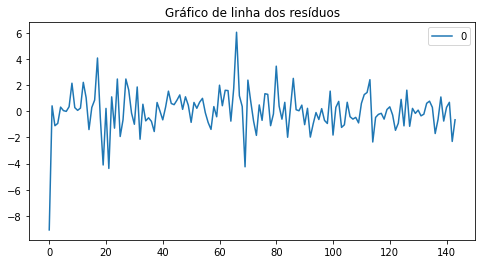

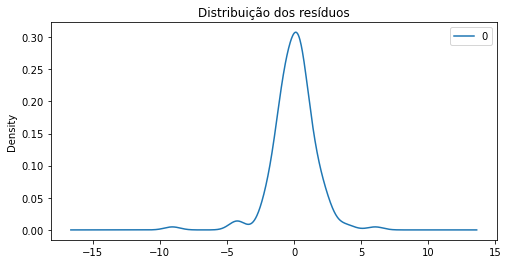

                0
count  144.000000
mean     0.014701
std      1.596280
min     -9.073897
25%     -0.744027
50%      0.142672
75%      0.713749
max      6.048218


In [48]:
# Gera Auto ARIMA
# Por padrão da biblioteca, o critério de informação é o AIC (também)
# e o teste de estacionariedade é o KPSS.
model = pm.auto_arima(train)
print(model.summary())

# Gera Previsões
auto_forecasts = model.predict(test.shape[0])

show_resid(model.resid())

# Salva estatística de erro
add_mae('v2_auto_arima', model.order, test, auto_forecasts)

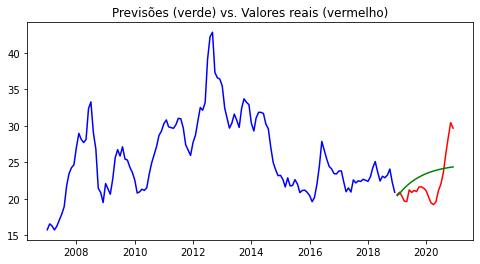

In [49]:
# Mostra previsões (azul=train, vermelho=test, verde=forecasts)
prev_real(df_mes, train, test, auto_forecasts)

---

**V3** Periodicidade mensal, AutoARIMA, janela móvel

In [50]:
# Seleciona a melhor ordem do ARIMA, automaticamente pelo autoarima
history = [x for x in train]
model = pm.auto_arima(history)
order_selected = model.order

mov_predictions = list()

# Loop que caminha ponto a ponto
for t in range(len(test)):
    model = ARIMA(history, order=order_selected).fit()
    if t == 0: print(model.summary())
    yhat = model.forecast()[0]
    
    # Gera Previsões
    mov_predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
# Salva estatística de erro
add_mae('v3_mensal_movel', order_selected, test, mov_predictions)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -255.587
Date:                Thu, 14 Jan 2021   AIC                            521.174
Time:                        16:26:56   BIC                            536.023
Sample:                             0   HQIC                           527.208
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8211      1.913     12.974      0.000      21.072      28.571
ar.L1          0.9052      0.029     31.076      0.000       0.848       0.962
ma.L1          0.4753      0.093      5.134      0.0

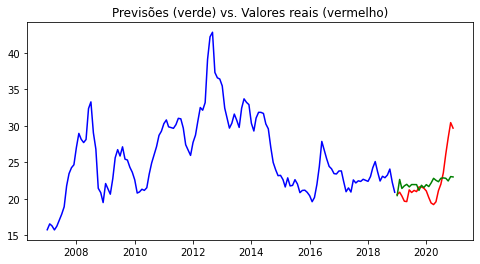

In [51]:
# Mostra previsões (azul=train, vermelho=test, verde=forecasts)
prev_real(df_mes, train, test.values, predictions)

---

**V4** Periodicidade diária, AutoARIMA, previsão pontual

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3366
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1586.307
Date:                Thu, 14 Jan 2021   AIC                           3174.613
Time:                        16:27:02   BIC                           3180.734
Sample:                             0   HQIC                          3176.802
                               - 3366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1503      0.001    154.634      0.000       0.148       0.152
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            100063.31
Prob(Q):                              0.69   Pr

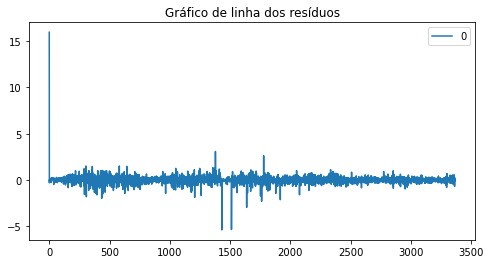

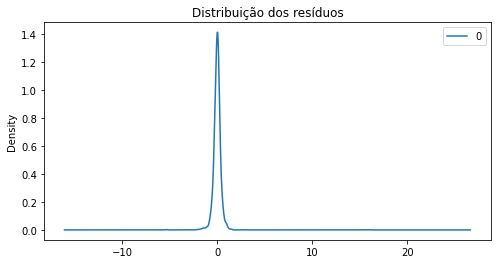

                 0
count  3366.000000
mean      0.006298
std       0.475262
min      -5.380000
25%      -0.180000
50%       0.020000
75%       0.190000
max      15.950000


In [52]:
# Modelo AutoARIMA, com previsão pontual para todo set de validação, na periodicidade diária
# Para fins de comparação com o modelo Facebook Prophet (previsão pontual, periodicidade diária)
history = [x for x in train_o]
model = pm.auto_arima(history)

# Sumário
print(model.summary())

# Gera Previsões
auto_forecasts = model.predict(test_o.shape[0])

# Print estatística de erro
print(model.order)
print(mean_absolute_error(test_o, auto_forecasts))

# Plota resíduos
show_resid(model.resid())

# Salva estatística de erro
add_mae('v4_diario_pontual', model.order, test_o, auto_forecasts)

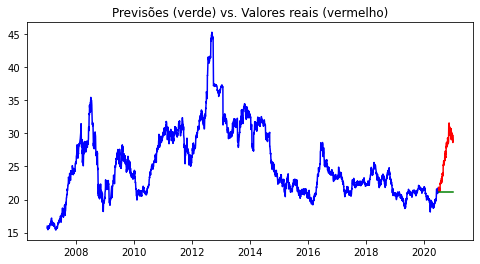

In [53]:
# Mostra previsões (azul=train, vermelho=test, verde=forecasts)
prev_real(df, train_o, test_o, auto_forecasts)

---

**V5** Periodicidade diária, AutoARIMA, janela móvel

Com a série na periodicidade original (diária), faremos uma previsão móvel, em que, a cada passo, é previsto apenas o próximo valor da variável *target*, incluindo o seu valor real no set de treino ao final da iteração e reexecutando os passos, até chegar ao final.

In [54]:
# Seleciona a melhor ordem do ARIMA, automaticamente pelo autoarima
history = [x for x in train_o]
model = pm.auto_arima(history)
order_selected = model.order

predictions = list()

# Loop que caminha ponto a ponto
for t in range(len(test_o)):
    model = ARIMA(history, order=order_selected).fit()
    if t == 0: print(model.summary())
    yhat = model.forecast()[0]
    
    # Gera Previsões
    predictions.append(yhat)
    obs = test_o[t]
    history.append(obs)
    
# Salva estatística de erro
add_mae('v5_diario_movel', order_selected, test_o, predictions)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3366
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1586.307
Date:                Thu, 14 Jan 2021   AIC                           3174.613
Time:                        16:27:07   BIC                           3180.734
Sample:                             0   HQIC                          3176.802
                               - 3366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1503      0.001    154.634      0.000       0.148       0.152
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            100063.31
Prob(Q):                              0.69   Pr

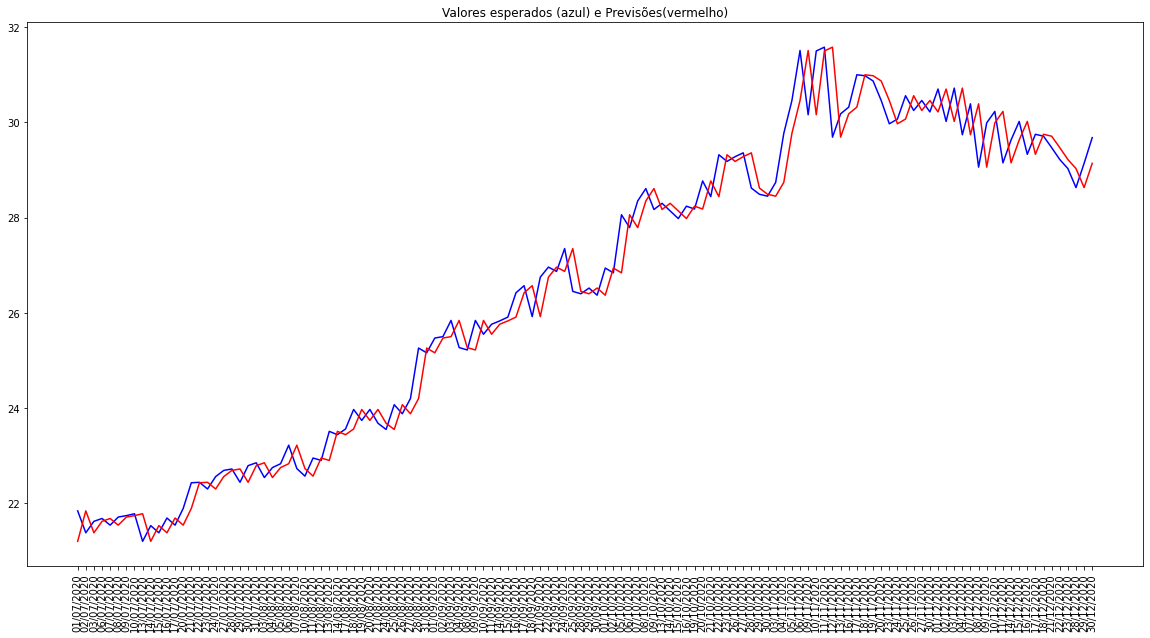

In [55]:
# plot previsões contra valores esperados
rcParams['figure.figsize'] = 20, 10

plt.plot(test_o.values, color='blue')
plt.plot(predictions, color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho)')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.show()

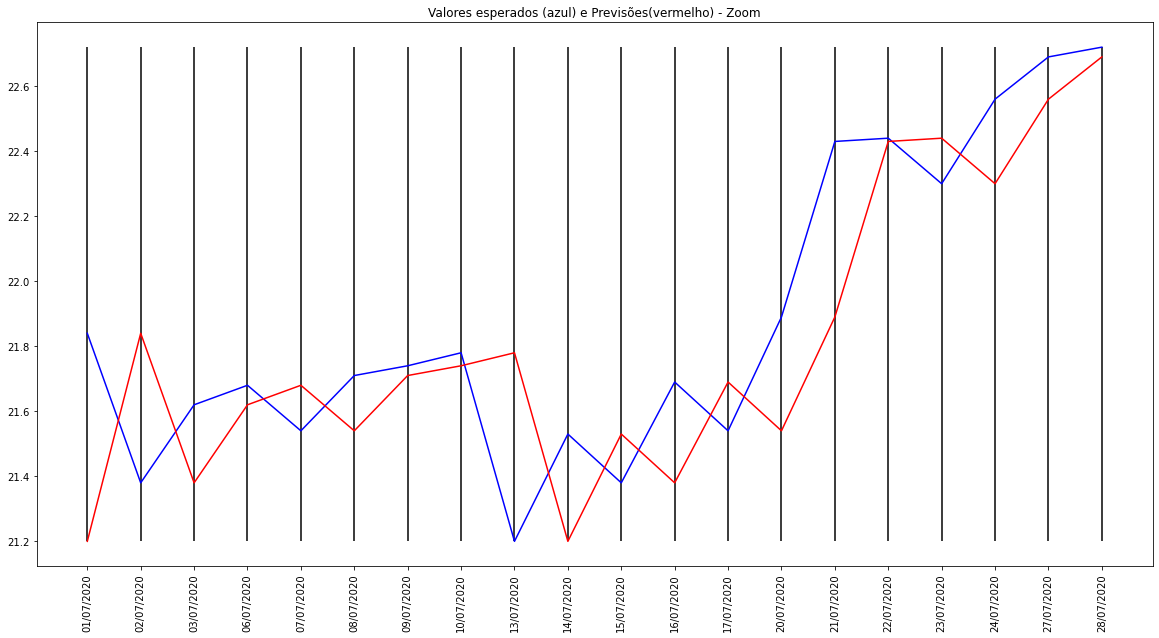

In [56]:
# plot previsões contra valores esperados, com "zoom" e linhas verticais
limite = slice(20)

plt.plot(test_o.values[limite], color='blue')
plt.plot(predictions[limite], color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho) - Zoom')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.vlines(np.arange(test_o.size)[limite], ymin=min(test_o[limite]), ymax=max(test_o[limite]), colors='k', linestyles='solid')
plt.show()

In [57]:
# Estatísticas de erro compara v1 e v2

menor_mae = np.inf

print("\n","*"*6,"RELATÓRIO DE ERROS","*"*6)

for k, c in mae.items():
    print('\n')
    print(f'{k} de ordem pqd {c["order"]}')
    print(f'obteve o erro MAE {"%.4f"}' % c["mae"])
    
    if c['mae'] < menor_mae:
        menor_mae = c['mae']
        melhor_order = c['order']
        melhor_metodo = k

print('\n', "*" * 33 , "\n")
print('Melhor resultado: \n')
print(f'*{melhor_metodo.upper()} ,*', f'pqd {melhor_order} ,', f' erro: { "%.4f" }' % menor_mae)


 ****** RELATÓRIO DE ERROS ******


v1_aic_brute de ordem pqd (0, 1, 1)
obteve o erro MAE 2.0073


v2_auto_arima de ordem pqd (1, 0, 2)
obteve o erro MAE 2.3868


v3_mensal_movel de ordem pqd (1, 0, 2)
obteve o erro MAE 0.6789


v4_diario_pontual de ordem pqd (0, 1, 0)
obteve o erro MAE 5.3624


v5_diario_movel de ordem pqd (0, 1, 0)
obteve o erro MAE 0.3838

 ********************************* 

Melhor resultado: 

*V5_DIARIO_MOVEL ,* pqd (0, 1, 0) ,  erro: 0.3838
